# Fitting an EAM potential
EAM potentials are pair functionals. 
In a generalised form they are equal to Finnis-Sinclair, effective medium theory or glue potentials. Their total energy can be written as

$E = \sum_{ij}V(r_{ij}) + \sum_i F(\rho_i)$

with

$\rho_i = \sum_j \rho(r_{ij})$

The original functions for V, $\rho$ and F were derived from different theories, but they can be chosen freely.

Fitting is done using atomicrex https://atomicrex.org. In the fit process an objective or cost function is minimized. The objective function is defined as

$\chi^2 = \sum_i w_i r_i$

where $w_i$ is a weight and $r_i$ is a residual that describes the difference to target values. This residual can be defined in different ways, so it is not possible to simply compare the residual for different fitting processes or codes. A more in depth explanation and some examples can be found on https://atomicrex.org/overview.html#objective-function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyiron import Project, ase_to_pyiron

### Import the training data

In [2]:
data_pr = Project("../../datasets")
if len(data_pr.job_table()) == 0:
    data_pr.unpack("Cu_training_archive")
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:53.061360,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,2,finished,None,df3_10k,/df3_10k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:55.496691,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
2,3,finished,None,df2_1k,/df2_1k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:56.101883,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
3,4,finished,None,df4_2_5eV_25A3_8K,/df4_2_5eV_25A3_8K,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:57.547918,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


In [3]:
data_job = data_pr.load("df1_A1_A2_A3_EV_elast_phon")
df = data_job.to_pandas()

In [4]:
pr = Project("WorkshopPotential")
#pr.remove_jobs()

### Create an atomicrex job

In [5]:
job = pr.create_job(pr.job_type.Atomicrex, "PotentialDF1")

### Add the structures that should be fitted.
It is possible to assign different weights to certain structures or properties, depending on what should be investigated using the potential. Here every structure has the same weight, but the force vector with N*3 values is normalized to have the same total weight as the single value energy. Therefore it is divided by the number of atoms. 

In [6]:
for id, row in df.iterrows():
    struct = ase_to_pyiron(row.atoms)
    s = job.structures.add_structure(struct, f"id{id}", relative_weight=1)
    s.fit_properties.add_FitProperty("atomic-energy", target_value=row.energy/row.number_of_atoms, relative_weight=1)
    s.fit_properties.add_FitProperty("atomic-forces", target_value=row.forces, relative_weight=1/row.number_of_atoms)

### Define the type of potential and necessary functions.
In this case an eam potential is fitted.

In [7]:
job.potential = job.factories.potentials.eam_potential()

It is necessary to define a pair potential, an electronic density function and an embedding function.
For all of those it is possible to choose between different functional forms.
Classic pair potentials are physically motivated and  have a very limited number of paramaters that can often be derived from an experimentally measurable quantity.
Splines or polynomials offer more flexibility, but can lead to unphysical oscillations or overfitting. Compared with the machine learning potentials shown later the number of parameters is very low no matter which functions you choose and the problem is highly non linear.

In this case a generalized morse function is used for the pair interaction. It has the form

$(\frac{D_0}{S-1}exp(-\beta \sqrt{2S}(r-r_0))-\frac{D_0S}{S-1}exp(-\beta\sqrt{2/S}(r-r_0)))+\delta $

The parameters in the morse potential can be derived from phyiscal quantities, here they are just educated guesses. For example $r_0$ is the equilibrium distance of a dimer. The nearest neighbor distance in fcc Cu is about 2.5 $\mathring A$ so it is taken as initial value.
In the case of analytic functions the initial parameter choices should not matter too much, since the functional form is constrained.

The electronic density and embedding function will be splines. Their initial parameters require more testing and hand tuning than the parameters of analytic functions. Depending on the properties that are calculated other functional forms could give better results. 

In [8]:
V = job.factories.functions.morse_B(identifier="V_CuCu", D0=0.35, r0=2.5, beta=2, S=2, delta=0)

Pre defined functions like the morse function can be plotted to see the influence of the initial parameter values

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:xlabel='r [$\\AA$]', ylabel='func(r)'>)

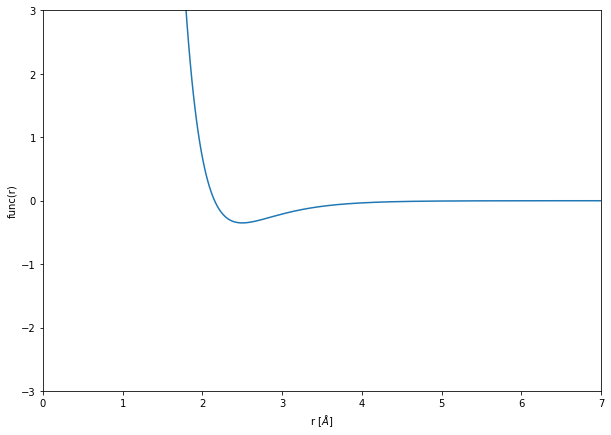

In [9]:
V.plot()

Additionally it is a good idea to define limits for the parameters. This is optional for local minimizers, but the fit can quickly run away without limits. Global optimizers typically require them to constrain the sampled space.

In [10]:
V.parameters.D0.min_val = 0
V.parameters.D0.max_val = 2
V.parameters.r0.min_val = 1.5
V.parameters.r0.max_val = 3.0
V.parameters.S.min_val = 1.1
V.parameters.S.max_val = 10.0
V.parameters.delta.min_val = -1
V.parameters.delta.max_val = 1
V.parameters.beta.min_val = 0.1
V.parameters.beta.max_val = 10

A screening function needs to be defined for the morse potential

In [11]:
V.screening  = job.factories.functions.exp_A_screening(identifier="V_cutoff", cutoff=7)

The electron density is chosen to be a spline function. The cutoff has to be defined. Derivatives left and right are optional, they default to 0. For the right cutoff this is fine, since the forces should smoothly go to 0. For the left this is not necessarily the best choice, since the function value should increase at very close distances. Very large absolute values will lead to osciallations and should be avoided.

In [12]:
rho = job.factories.functions.spline(identifier="rho_CuCu", cutoff=7, derivative_left=-1)

For a spline function it is necessary to define node points. They can be equally spaced or sampled with higher density around turning points, f.e. the first neighbor distance.
Too few nodepoints mean low flexibilty, too many lead to overfitting. This requires some testing to find an optimal choice.

In [13]:
rho_nodes = np.linspace(0.5, 7.0, 7).round(2)
rho_nodes

array([0.5 , 1.58, 2.67, 3.75, 4.83, 5.92, 7.  ])

The nodes need initial values. The electron density should be proportional to $e^{-r}$, so this function is chosen to calculate them.

In [14]:
decaying_exp = lambda r: np.exp(-r)
rho_initial = decaying_exp(rho_nodes)

A density can't be negative so the lower limit is set to 0. The upper limit is chosen to be 3 times the initial values. These choices aswell as the choice for $e^{-r}$ as initial values are somewhat arbitrary. The electron density from single atoms does not directly influence the calculated energies and forces, instead the summed up density at some place is used in the embedding function, so the final numerical values are an interplay between electron density and embedding function. Since the latter will also be a spline function it can only be defined for a certain range of rho values as node points. Therefore it is better to limit the range of electron density values and define larger limits for the embedding function instead. 

In [15]:
rho_mins = np.zeros((len(rho_nodes)))
rho_maxs = 3*rho_initial.round(6)
rho.parameters.create_from_arrays(rho_nodes, rho_initial, min_vals=rho_mins, max_vals=rho_maxs)

In [16]:
rho.parameters["node_7.0"].start_val = 0
rho.parameters["node_7.0"].enabled = False

$-\sqrt(\rho)$ can be used as initial guess for the embedding energy, which is taken from second moment approximation tight binding. 
The node points have to be chosen in a range compatible to the electron density. This can be estimated by calculating it for a densely packed structure.
Alternatively atomicrex writes the maximum electron density of all structures to the output. This can be used as a hint for the node points for consequent fits.
Everything else is similar to the electron density.

In [17]:
F = job.factories.functions.spline(identifier="F_CuCu", cutoff=5)
F_nodes = np.linspace(0.0, 5.0, 7).round(2)
F_init = -np.sqrt(F_nodes)
F_maxs = np.zeros(len(F_nodes))
F_mins = -np.ones(len(F_nodes))*5
F.parameters.create_from_arrays(F_nodes, F_init, F_mins, F_maxs)
F.parameters["node_0.0"].enabled=False
F.parameters["node_0.0"].start_val = 0
F.parameters["node_5.0"].enabled=False
F.parameters["node_5.0"].start_val = 0

The functions have to be assigned to the potential

In [18]:
job.potential.pair_interactions[V.identifier] = V
job.potential.electron_densities[rho.identifier] = rho
job.potential.embedding_energies[F.identifier] = F

### Define fitting procedure
Finally atom types and fit algorithm have to be assigned.
Atomicrex itself implements the BFGS algorithm. Additionally the algorithms from the nlopt library can be used.

In [19]:
## Define the atom types of the potential
job.input.atom_types.Cu = None
## Limited number of iterations for the workshop
job.input.fit_algorithm = job.factories.algorithms.ar_lbfgs(max_iter=500)
job.run()
job.output

The job PotentialDF1 was saved and received the ID: 55


Output({'error': None, 'residual': array([1.39371e+03, 1.39371e+03, 1.39371e+03, 1.39285e+02, 1.39285e+02,
       1.37569e+02, 1.32438e+02, 1.32438e+02, 1.27976e+02, 1.27976e+02,
       1.25789e+02, 1.25789e+02, 1.11972e+02, 1.11972e+02, 9.29037e+01,
       9.29037e+01, 7.04972e+01, 7.04972e+01, 6.41238e+01, 6.41238e+01,
       6.36689e+01, 6.36689e+01, 6.32335e+01, 6.17085e+01, 6.17085e+01,
       6.12704e+01, 6.12704e+01, 5.46626e+01, 5.46626e+01, 5.34871e+01,
       5.34871e+01, 5.19145e+01, 5.19145e+01, 5.10759e+01, 5.10759e+01,
       4.91619e+01, 4.91619e+01, 4.81833e+01, 4.81833e+01, 3.96327e+01,
       3.96327e+01, 1.62620e+01, 1.62620e+01, 9.12295e+00, 9.12295e+00,
       9.12295e+00, 8.51678e+00, 8.51678e+00, 4.84582e+00, 4.84582e+00,
       4.59833e+00, 4.59833e+00, 4.58112e+00, 4.58112e+00, 4.51002e+00,
       4.51002e+00, 4.40158e+00, 4.40158e+00, 4.21667e+00, 4.21667e+00,
       4.13865e+00, 4.13865e+00, 4.00862e+00, 4.00862e+00, 3.90090e+00,
       3.90090e+00, 3.88944e+

### Plot the results

Plot the resiudal over steps to see how the calculation converges

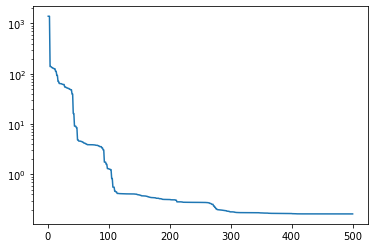

In [20]:
plt.plot(job.output.iterations, job.output.residual)
plt.yscale("log")

Finally it is a good idea to have a look at the final potential. This can reveal unphysical behavior

(<Figure size 576x1296 with 3 Axes>,
 array([[<AxesSubplot:title={'center':'Cu F'}, xlabel='$\\rho $ [a.u.]'>],
        [<AxesSubplot:title={'center':'Cu rho_CuCu'}, xlabel='r [$\\AA$]'>],
        [<AxesSubplot:title={'center':'Cu V_CuCu'}, xlabel='r [$\\AA$]'>]],
       dtype=object))

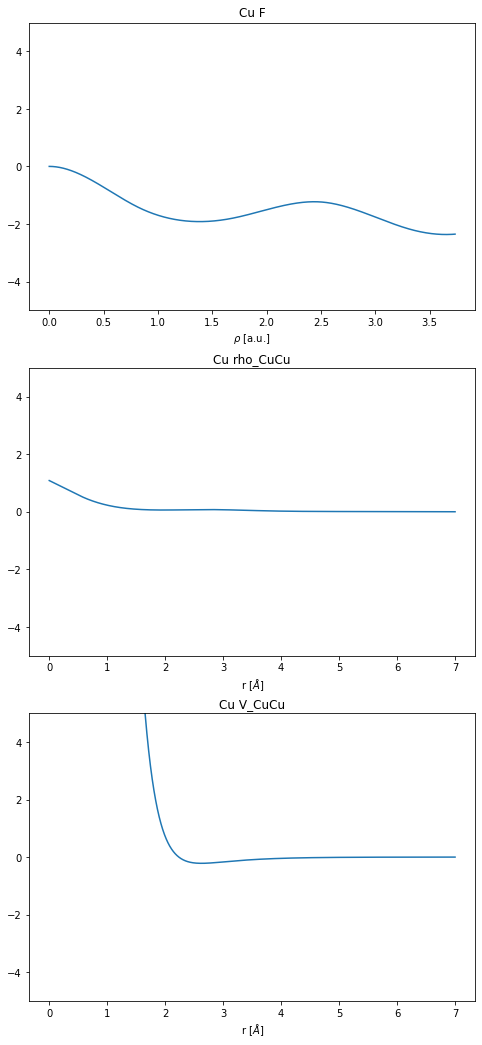

In [21]:
job.plot_final_potential()

### Run a lammps simulations with the fitted potential

In [22]:
lmp = pr.create_job("Lammps", "template")
lmp.structure = pr.create_ase_bulk("Cu", cubic=True)
lmp.potential = job.lammps_potential
murn = lmp.create_job("Murnaghan", "PotentialTest")
murn.run()

The job PotentialTest was saved and received the ID: 56
The job strain_0_9 was saved and received the ID: 57
The job strain_0_92 was saved and received the ID: 58
The job strain_0_94 was saved and received the ID: 59
The job strain_0_96 was saved and received the ID: 60
The job strain_0_98 was saved and received the ID: 61
The job strain_1_0 was saved and received the ID: 62
The job strain_1_02 was saved and received the ID: 63
The job strain_1_04 was saved and received the ID: 64
The job strain_1_06 was saved and received the ID: 65
The job strain_1_08 was saved and received the ID: 66
The job strain_1_1 was saved and received the ID: 67
job_id:  57 finished
job_id:  58 finished
job_id:  59 finished
job_id:  60 finished
job_id:  61 finished
job_id:  62 finished
job_id:  63 finished
job_id:  64 finished
job_id:  65 finished
job_id:  66 finished
job_id:  67 finished


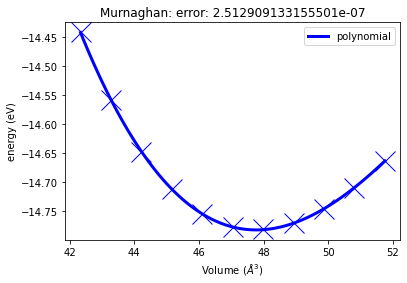

In [23]:
murn.plot()

In [24]:
murn["output/equilibrium_volume"]**(1/3)

3.6284997615253496

### Same cane be done for the 1000 structures dataset
The final parameters of the 100 structure fit can be used for the 1000 Structure fit. This can speed up the fitting process and often leads to better results, especially if the initially guessed values are far from the optimum. 

In general it is a good idea to start with few structures and try around with different functions and initial parameters. This is much faster than using all structures from the beginning and gives good guesses for the initial values of the parameters. It also allows to use global optimization with millions of steps in short time spans.

### This can take long and writes 1000 seperate POSCAR files, TAKE CARE
Run these jobs with more cores or more time after the workshop. Also increase the number of iterations for better results

In [25]:
pr = Project("PotentialDF2")
#pr.remove_jobs()
j = pr.create_job(pr.job_type.Atomicrex, "PotentialDF2")
j.potential = job.potential.copy()
## Use the final parameters as starting values for the new fit
j.potential.copy_final_to_initial_params()

In [26]:
df = data_pr.load("df2_1k").to_pandas()
for id, row in df.iterrows():
    struct = ase_to_pyiron(row.atoms)
    s = j.structures.add_structure(struct, f"id{id}", relative_weight=1)
    s.fit_properties.add_FitProperty("atomic-energy", target_value=row.energy/row.number_of_atoms, relative_weight=1)
    s.fit_properties.add_FitProperty("atomic-forces", target_value=row.forces, relative_weight=1/row.number_of_atoms)

In [27]:
import time

In [28]:
j.input.atom_types.Cu = None
j.input.fit_algorithm = j.factories.algorithms.ar_lbfgs(max_iter=100000)

## if possible increase number of cores
#j.server.cores = 16
t1 = time.time()
## Uncomment if you want to run the job
#j.run()
t2 = time.time()

In [29]:
t2-t1

4.696846008300781e-05

In [30]:
j.output

Output({'error': None, 'residual': None, 'iterations': None})

This is the result if the initilly guessed values are taken instead of the fitted ones.

In [31]:
j2 = pr.create_job(pr.job_type.Atomicrex, "PotentialDF2_BadStartParams")
j2.potential = job.potential.copy()
j2.input.atom_types.Cu = None
j2.input.fit_algorithm = j.factories.algorithms.ar_lbfgs(max_iter=100000)
j2.structures = j.structures
## if possible increase number of cores
#j2.server.cores = 16
## Uncomment if you want to run the job
#j2.run()

In [32]:
j2.output

Output({'error': None, 'residual': None, 'iterations': None})

With this choice of functions and initial parameters starting directly from all structures gives the same residual. In a previous iteration of the potential it was about 7 times worse, so it is a good idea to test this.